# imports, read in data

In [1]:
from matplotlib import rcParams

# meaning of the var axis values?
# each cell sums to 0
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns


import os
import scanpy as sc 
import numpy as np
import pandas as pd 

In [2]:
sc.set_figure_params()

In [3]:
raman_data = sc.read('raman_data.h5ad')
omics_data = sc.read('omics_data.h5ad')

serum_text = pd.read_csv('../../../data/scRNAseq/serum_cell_ids.txt')
serum_text = list(np.squeeze(serum_text.to_numpy()))

res = [
    x in serum_text for x in omics_data.obs.index
]

omics_data.obs['good_serum'] = res

omics_data = omics_data[omics_data.obs['good_serum']]


g = omics_data.obs.groupby('leiden_cell_type')
omics_data_bal_obs = g.apply(lambda x: x.sample(g.size().min(), random_state=2000))#.reset_index(level=['leiden']))#drop=True))

mask = [idx[1] for idx in omics_data_bal_obs.index]
omics_data_bal = omics_data[mask,:]
omics_data = omics_data_bal

/home/kkobayas/miniconda3/envs/gan/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
from sklearn.model_selection import train_test_split
import random
random.seed(0)

raman_genes = [
    'Pou5f1',
    'Peg10',
    'Utf1',
    'Krt7',
    'Epcam',
    'Bgn',
    'Nnat',
    'Col1a1',
    'Fabp7',
    'Nanog',
]

# then min max normalization of the omics data
# for gene in raman_genes:
#     print(gene, gene in omics_data.var.index)
# they are all in the omics data

omics_data.X = np.array(omics_data.X) / (1<<5)

omics_test_datas = omics_data


omics_test = omics_data

omics_train = omics_data
# for day in training_days:
    # omics_train = omics_train[omics_train.obs['day']!=float(day)]

raman_data.X = raman_data.X / 15.


raman_shuff = raman_data.copy()
half = raman_shuff.shape[0] // 2
ind = np.arange(raman_shuff.shape[0])
random.shuffle(ind)
raman_test = raman_shuff[ind[:half],:]
raman_train = raman_shuff[ind[half:]]

# model / learning infrastructure

In [8]:

from torch.utils.data import TensorDataset, DataLoader
import torch

def make_dataset(tissue, sample, num_extra=0):
    our_data = processed_adata[processed_adata.obs['patient']==sample]
    our_data = our_data[our_data.obs['tissue']==tissue]
    res_numpy = our_data.X
    extra_index = np.random.choice(res_numpy.shape[0], num_extra, replace=True)
    extra_res_numpy = res_numpy[extra_index]
    res_numpy = np.concatenate([res_numpy, extra_res_numpy], axis=0)
    final_res = torch.from_numpy(res_numpy)
    return final_res


patient_to_label = {
    f'BC{i + 1}': i for i in range(8)
}


def make_data_loader(tissue, samples, with_labels=True, batch_size=1<<7):
    our_data = processed_adata[processed_adata.obs['tissue']==tissue]
    sample_to_more_data = {
        sample: our_data[our_data.obs['patient']==sample]
        for sample in samples
    }
    
    res = sample_to_more_data[samples[0]]
    res_labels = np.zeros(res.shape[0]) + patient_to_label[samples[0]]
    res = res.concatenate(*[v for k, v in sample_to_more_data.items() if k != samples[0]])
    res_labels = np.concatenate([res_labels] + [ np.zeros(v.shape[0]) + patient_to_label[k] for k, v in sample_to_more_data.items() if k != samples[0]])
    res_numpy = res.X
    
    from_which = [
        torch.from_numpy(res_numpy),
    ]
    
    if with_labels:
        from_which.append(torch.from_numpy(res_labels))
        
    final_res = DataLoader(
        TensorDataset(
            *from_which,
        ), batch_size=batch_size, shuffle=True,
        num_workers=1, pin_memory=True, drop_last=True,
    )
    return final_res

def make_train_test_split_tensors(tissue, train_samples, test_samples):
    our_data = processed_adata[processed_adata.obs['tissue']==tissue]
    sample_to_more_data = {
        sample: our_data[our_data.obs['patient']==sample]
        for sample in train_samples + test_samples
    }
    
    res_train = sample_to_more_data[train_samples[0]]
    if len(train_samples) > 1:
        res_train = res_train.concatenate(*[v for k, v in sample_to_more_data.items() if k != train_samples[0] and k in train_samples])
    res_test = sample_to_more_data[test_samples[0]]
    if len(test_samples) > 1:
        res_test = res_test.concatenate(*[v for k, v in sample_to_more_data.items() if k != test_samples[0] and k in test_samples])
    return torch.from_numpy(res_train.X).to('cpu'), torch.from_numpy(res_test.X).to('cpu')
    
###### BELOW are more models and more losses

# we now have information regarding the spatiality of the VIM gene

import os


# no tesnorflow, being very uncooperative
import torch
# import torchvision
# import torchsummary

import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as U
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


import numpy as np
import scipy as sp
import pandas as pd

import sys
sys.path.extend([".", ".."])

def turn_on_model(model):
    for param in model.parameters():
        param.requires_grad = True
        
def turn_off_model(model):
    for param in model.parameters():
        param.requires_grad = False

        
# better new arch    
class StandardEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super(StandardEncoder, self).__init__()
        self.part1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # x tra here
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),  # x tra end 
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
        )
        
        self.to_mean = nn.Linear(hidden_dim, latent_dim)
        self.to_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent_dim = latent_dim
    
    def forward(self, x):
        x = self.part1(x)
        return self.to_mean(x), self.to_logvar(x)
    
    
class StandardDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512, no_final_relu=False):
        super(StandardDecoder, self).__init__()
     
        
        # this is for the case of non-zinb
        if no_final_relu:
            self.net = nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),  # x tra start here
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),  # xtra end
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim),
#                 nn.ReLU(),  # do the activation here
            )
            
        else:
            self.net = nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),  # x tra start here
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),  # xtra end
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim),
                nn.ReLU(),  # do the activation here
            )
        
        self.latent_dim = latent_dim
    
    # returns a tuple regardless
    def forward(self, x):
        res = self.net(x)
        return res



class Discriminator(nn.Module):
    def __init__(self, latent_dim, spectral=True, end_dim=2):
        super(Discriminator, self).__init__()
        if spectral:
            self.net = nn.Sequential(
                U.spectral_norm(nn.Linear(latent_dim, 1<<6)),
                nn.ReLU(),
                U.spectral_norm(nn.Linear(1<<6, 1<<5)),
                nn.ReLU(),
                U.spectral_norm(nn.Linear(1<<5, 1<<5)),
                nn.ReLU(),
                U.spectral_norm(nn.Linear(1<<5, end_dim)),
    #             nn.Sigmoid(), just do w logits for now 
            )
        else:
            self.net = nn.Sequential(
                nn.Linear(latent_dim, 1<<6),
                nn.ReLU(),
                nn.Linear(1<<6, 1<<5),
                nn.ReLU(),
                nn.Linear(1<<5, 1<<5),
                nn.ReLU(),
                nn.Linear(1<<5, end_dim),
    #             nn.Sigmoid(), just do w logits for now 
            )
        
    def forward(self, x):
        return self.net(x)
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder, is_vae=True, use_latent_norm=True):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.is_vae = is_vae
        self.latent_normalizer = (
            nn.BatchNorm1d(self.encoder.latent_dim) if 1
            else nn.Sigmoid()
        )
        self.use_latent_norm = use_latent_norm 
        
    def reparam_trick(self, mean, logvar):
        sigma = torch.exp(0.5*logvar)
        eps = torch.randn_like(sigma)
        res = (
            mean + eps*sigma if self.is_vae
            else mean
        )
        return res
        # below is stupid garbo
        # this was a massive BUG
#         return mean + eps*sigma
#         return mean  # for non variational version, uncomment
    
    def get_latent(self, x):
        mean, logvar = self.encoder(x)
            
        if self.use_latent_norm:
            mean = self.latent_normalizer(mean)
            logvar = self.latent_normalizer(logvar)
            
        return self.reparam_trick(mean, logvar)
    
    def forward(self, x, noise_latent_lambda=0.):
        mean, logvar = self.encoder(x)
        
        if self.use_latent_norm:
            if 0:
                mean = self.latent_normalizer(mean)
                logvar = self.latent_normalizer(logvar)
            
            
                latent = self.reparam_trick(mean, logvar)
            else:
                latent = self.reparam_trick(mean, logvar)
                latent = self.latent_normalizer(latent)
        else:
            latent = self.reparam_trick(mean, logvar)
            
        if noise_latent_lambda:
            latent = latent + noise_latent_lambda*torch.randn_like(latent)
            
        
#         m_bar, pi, theta = self.decoder(latent)
        # return everything , last 3 are mean, logvar, latent

        recon_x = self.decoder(latent)
        return recon_x, mean, logvar, latent
       
    
#### LOSS FUNCTIONS
# gives option for VAE type of loss
def old_mse_loss(x, recon_x, weights=None):
    return F.mse_loss(
        recon_x, x, 
    ) * 1e5


def discrim_criter(pred, true):
    return F.binary_cross_entropy_with_logits(
        pred, true,
    ) * 1e5


def weighted_mse(a, b, weights=None):
    return (
        torch.sum(((a-b)**2)*weights) if (weights is not None)
        else F.mse_loss(a, b)
    ) * 1e5

def old_vae_loss(x, recon_x, mean, logvar, weights=None, this_lambda=0.,):
    if weights is None:
        bce = F.mse_loss(
            recon_x, x, 
        ) * 1e5  # poss comment out last part 
    else:
        bce = weighted_mse(recon_x, x, weights=weights)
   
    kl_div = -.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    return bce + this_lambda*kl_div

def discrim_loss(pred, true):
    return F.binary_cross_entropy_with_logits(
        pred, true, 
    ) * 1e5

# don't do any requires_grad stuff in here
def adv_vae_loss(
    x, recon_x, 
    mean, logvar, discrim_preds,
    alpha, beta, weights=None,
):
    vae_part_loss = old_vae_loss(
        x, recon_x, mean, logvar, weights=weights)
    source_label = [1., 0.]
    target_label = [0., 1.]
    discrim_labels = torch.tensor([source_label] * x.shape[0]).to(device)
    total_discrim_loss = F.binary_cross_entropy_with_logits(
        discrim_preds, discrim_labels, 
    ) * 1e5
    
    discrim_part_loss = beta * total_discrim_loss
    return alpha * vae_part_loss + discrim_part_loss, vae_part_loss, total_discrim_loss



# train reference omics model

In [9]:
# include everything or only the non clonotypes
# do everything (how gte the clonotypes)


device = torch.device("cuda")
train_feature = omics_train.X.todense() / .1  # don't have this

# very small number on this one 
batch_size = 1<<7
epochs = 30  

ref_data_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(train_feature),
    ), batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True,
)

input_cell_dim = 19089


# ODD FINDING - DEEPER MAKES LATENT SPACE LOOK BETTER
# ALSO LARGER HIDDEN DIM BY FACTOR OF 2
ref_vae = VAE(
    StandardEncoder(input_cell_dim, 1<<7, hidden_dim=1<<11),  # hidden was 1<<10
    StandardDecoder(input_cell_dim, 1<<7, hidden_dim=1<<11,),
    is_vae=False,
    use_latent_norm=True,  # was True for all else 
).to(device)

ref_vae_opt = optim.Adam( #5-5 is 181
    ref_vae.parameters(), lr=1e-5, #betas=(.5,.999), 5e get .074, after 10, same is avg .057
)

ref_vae.to(device)

epoch_losses = []
    
need_retrain = 0    
if need_retrain:    
    epochs = 30
    # got to < .115 avg loss after 150 epochs
    # best was ====> Epoch: 1000 Average loss: 0.0979890559

    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for _id, [batch,] in enumerate(ref_data_loader):
            batch = batch.to(device)
            ref_vae_opt.zero_grad()

            recon_x, mean, logvar, latent = ref_vae(batch)
            batch_loss = old_vae_loss(
                batch, recon_x, mean, logvar, weights=None,
            )


            batch_loss.backward()
            epoch_loss += batch_loss.item()
            ref_vae_opt.step()
            if not (_id % 500):
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.10f}'.format(
                    epoch, 
                    _id * len(batch), 
                    len(ref_data_loader.dataset),
                    25. * _id / len(ref_data_loader),
                    batch_loss.item() / len(batch),
                ))

        print('====> Epoch: {} Average loss: {:.10f}'.format(
                  epoch, epoch_loss / len(ref_data_loader.dataset)))

        epoch_losses.append(epoch_loss)

else:
    ref_vae.load_state_dict(torch.load('ref_vae.pt'))


In [10]:
latent_dim = 1<<7
ref_vae = ref_vae.to('cpu')

orig_cells_dataset = (
    torch
    .from_numpy(train_feature)
    .float()
    .to('cpu')
)

_, _, _, latent = ref_vae(orig_cells_dataset)

latent = latent.detach().numpy()

annos = np.unique(omics_data.obs['leiden_cell_type'])
anno_to_label = dict(zip(annos, range(len(annos))))
label_to_anno = dict(zip(range(len(annos)), annos))
final_output_shape = len(label_to_anno)

celltype_classifier = Discriminator(latent_dim, end_dim=final_output_shape).to(device)

celltype_classifier_opt = optim.Adam(
    celltype_classifier.parameters(), lr=1e-3,
)

batch_size = 1<<5


celltype_train_list = np.array([
    anno_to_label[ct] 
    for ct in omics_train.obs['leiden_cell_type']
])

celltype_data_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(latent),
        torch.from_numpy(celltype_train_list),
    ), batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True,
)

num_cells = len(celltype_train_list)
class_weights = torch.tensor([
    (float(num_cells) / np.sum(celltype_train_list == class_label)) for class_label in range(final_output_shape)
]).float()

class_weights = class_weights.to(device)
criter = nn.CrossEntropyLoss(weight=class_weights)


epochs = 32
celltype_classifier = celltype_classifier.to(device)
for epoch in range(epochs):
    epoch_loss = 0.0
    for _id, ([this_batch, this_label]) in enumerate(celltype_data_loader):
        this_batch = this_batch.to(device)
        this_label = this_label.to(device)
        celltype_classifier_opt.zero_grad()
        predicted_labels = celltype_classifier(this_batch.float())
        this_batch_loss = criter(
            predicted_labels,
            this_label,
        )
        this_batch_loss.backward()
        epoch_loss += this_batch_loss.item()
        celltype_classifier_opt.step()

    print('====> Epoch: {} Average loss: {:.10f}'.format(
          epoch+1, epoch_loss / len(celltype_data_loader.dataset)))

celltype_classifier = celltype_classifier.to('cpu')        
orig_pred_labels = celltype_classifier(torch.from_numpy(latent)).detach().numpy()
orig_pred_labels = np.argmax(orig_pred_labels, axis=1)
num_final_correct = np.sum(orig_pred_labels == celltype_train_list)

print(f'final_accuracy:{ num_final_correct / float(num_cells)}')
# get around 96 % accuracy, which is solid i suppose



====> Epoch: 1 Average loss: 0.0323096691
====> Epoch: 2 Average loss: 0.0164940101
====> Epoch: 3 Average loss: 0.0123578584
====> Epoch: 4 Average loss: 0.0116479484
====> Epoch: 5 Average loss: 0.0105483342
====> Epoch: 6 Average loss: 0.0103934862
====> Epoch: 7 Average loss: 0.0102246924
====> Epoch: 8 Average loss: 0.0099185053
====> Epoch: 9 Average loss: 0.0097769028
====> Epoch: 10 Average loss: 0.0093815150
====> Epoch: 11 Average loss: 0.0093704402
====> Epoch: 12 Average loss: 0.0091907984
====> Epoch: 13 Average loss: 0.0091069277
====> Epoch: 14 Average loss: 0.0091452164
====> Epoch: 15 Average loss: 0.0091140306
====> Epoch: 16 Average loss: 0.0089659583
====> Epoch: 17 Average loss: 0.0090166148
====> Epoch: 18 Average loss: 0.0088457544
====> Epoch: 19 Average loss: 0.0088389856
====> Epoch: 20 Average loss: 0.0085611198
====> Epoch: 21 Average loss: 0.0088328244
====> Epoch: 22 Average loss: 0.0084799953
====> Epoch: 23 Average loss: 0.0085695034
====> Epoch: 24 Aver

# train raman model to reconstruct

In [11]:
# train the adversarial wring of the model 
# first, do cross modal

latent_dim = 1<<7
sample1_beta = 4e-3 if 0 else 0 # for now, just have this as 0


input_cell_dim = 930

ref_vae = ref_vae.to(device)
raman_vae = VAE(
    StandardEncoder(input_cell_dim, 1<<7, hidden_dim=1<<11,),  # hidden was 1<<10
    StandardDecoder(input_cell_dim, 1<<7, hidden_dim=1<<11, no_final_relu=True,),
    is_vae=False,
    use_latent_norm=True,  # was True for all else 
).to(device)

raman_opt = optim.Adam(
    raman_vae.parameters(), lr=5e-5, #betas=(.5,.999), 5e get .074, after 10, same is avg .057
)

raman_vae.to(device)

raman_discrim = Discriminator(latent_dim).to(device)

raman_discrim_opt = optim.Adam(
    raman_discrim.parameters(), lr=4e-3,#5e-4,  # was 1e-5 before, 5e-6, best 1e-4
)


# now actually do the training  

alpha = 1e0  # maybe make this 0 

# 8e-4 was good before add in other sample
beta = 3e-4 if 1 else 8e-4 if 1 else 2e-3 if 1 else 0 #3e-4  #1e-2   # 1e-8, was best


# a good loss for the celltype is .006 ish
# 5 was good from when there was extra day 12 in the training 
raman_beta = 5e1 if 1 else 1e2 # make this big, see if helps


print(f"begin_raman_latent_train")

# variables of interest are:
    # raman_device
    # raman_vae
    # raman_opt
    # raman_discrim
    # raman_discrim_opt
    # raman_discrim_sched

# try this and just repeating the ref_key one many times 
# also make this multip gpus training this is taking a while 

# train_feature = omics_train.X / .1
train_feature = omics_train.X.todense() / .1
train_feature_raman = raman_train.X / .1  # see if this helps 
    
ref_data_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(train_feature),
    ), batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True,
)

raman_celltype_train_list = np.array([
    anno_to_label[ct] 
    for ct in raman_train.obs['tg_celltype']
])

raman_data_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(train_feature_raman),
        torch.from_numpy(raman_celltype_train_list),
    ), batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True,
)

celltype_classifier = celltype_classifier.to(device)
need_retrain_raman = 0
if need_retrain_raman:
    # maybe do just ten epochs
    epochs = 105 if 1 else 150 if 1 else 90 if 1 else 75 if 0 else 100 if 0 else 30 # (was 150 before)
    for epoch in range(1, epochs + 1):

        discrim_epoch_loss = 0.
        vae_part_epoch_loss = 0.
        raman_vae_epoch_loss = 0.
        celltype_part_epoch_loss = 0.
        print(f"begin epoch {epoch}")
        for _id, ([ref_batch,], [raman_batch, raman_celltypes], ) in enumerate(zip(
            ref_data_loader,
            raman_data_loader,
        )):

            raman_opt.zero_grad()
            raman_discrim_opt.zero_grad()
            ref_batch = ref_batch.to(device)
            raman_batch = raman_batch.to(device)
            raman_celltypes = raman_celltypes.to(device)

            ref_encoded = (
                ref_vae.get_latent(ref_batch)
                .detach()
            )

            raman_encoded = (
                raman_vae.get_latent(raman_batch)
                .detach()
            )

            # put all tensors on the right device 
            source_label, target_label = [1., 0.], [0., 1.]
            encodeds = torch.cat((ref_encoded, raman_encoded), axis=0)
            discrim_labels = torch.tensor(
                [source_label] * ref_encoded.shape[0]
                + [target_label] * raman_encoded.shape[0]
            ).to(device)

            pred_discrim_labels = raman_discrim(encodeds)
            batch_discrim_loss = discrim_loss(
                pred_discrim_labels, discrim_labels,
            )

            batch_discrim_loss.backward()
            discrim_epoch_loss += batch_discrim_loss.item()
            raman_discrim_opt.step()     


            #### second part
            for param in raman_discrim.parameters():
                param.requires_grad = False

            recon_raman_batch, raman_batch_mean, raman_batch_logvar, raman_batch_latent = raman_vae(raman_batch)

            # this was from before, do not use this
    #                 raman_batch_latent = raman_vae.reparam_trick(raman_batch_mean, raman_batch_logvar)
            raman_vae_discrim_preds = raman_discrim(raman_batch_latent)

            # set the discrim requires_grad to False 

            raman_vae_batch_loss, vae_part_batch_loss, _ = adv_vae_loss(
                raman_batch.detach(), recon_raman_batch, # second_batch_latent,
                raman_batch_mean, raman_batch_logvar, raman_vae_discrim_preds,
                alpha, beta,   # was 1e-1, 1e-2 was bad, 1e-1 was best 
            )

            #### next part THIS IS NEW 
            raman_celltype_preds = celltype_classifier(raman_batch_latent)
            raman_celltype_loss =  criter(raman_celltype_preds, raman_celltypes)
            raman_vae_batch_loss = raman_vae_batch_loss + raman_beta * raman_celltype_loss

            raman_vae_batch_loss.backward()
            celltype_part_epoch_loss += raman_celltype_loss.item()
            raman_vae_epoch_loss += raman_vae_batch_loss.item()
            vae_part_epoch_loss += vae_part_batch_loss.item()
            raman_opt.step()

            # undo the above
            for param in raman_discrim.parameters():
                param.requires_grad = True


            if not (_id % 500):
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses: {:.6f} {:.6f}'.format(
                epoch, _id * len(raman_batch), len(raman_data_loader.dataset),
                100. * _id / len(raman_data_loader),
                batch_discrim_loss.item() / len(raman_batch),
                raman_vae_batch_loss.item() / len(raman_batch)))

        print('====> Epoch: {} Average adv vae loss: {:.10f}'.format(
              epoch, raman_vae_epoch_loss / len(raman_data_loader.dataset)))

        print('====> Epoch: {} Average vae part loss: {:.10f}'.format(
              epoch, vae_part_epoch_loss / len(raman_data_loader.dataset)))

        print('====> Epoch: {} Average celltype part loss: {:.10f}'.format(
              epoch, celltype_part_epoch_loss / len(raman_data_loader.dataset)))

        print('====> Epoch: {} Average discrim vae loss: {:.10f}'.format(
              epoch, discrim_epoch_loss / len(raman_data_loader.dataset)))

        print(f"end epoch {epoch}")
        if 0 and vae_part_epoch_loss >  .9 * raman_vae_epoch_loss:
            beta *= 2
            print(f"updating at epoch {epoch} to beta {beta}")
    print(f"end_raman_latent_train")

else:
    raman_vae.load_state_dict(torch.load('raman_vae.pt'))    
    


begin_raman_latent_train


... storing 'cell_type' as categorical
... storing 'leiden' as categorical
... storing 'leiden_cell_type' as categorical
... storing 'image' as categorical
... storing 'pos' as categorical
... storing 'tg_celltype' as categorical


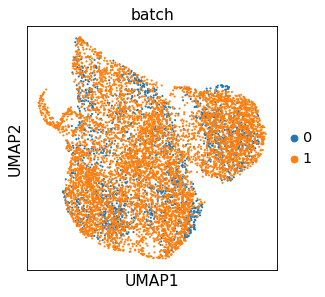

In [12]:
# see how well transferred and originals align
transfer_vae = VAE(
    raman_vae.encoder,
    ref_vae.decoder,
    is_vae=False,
    use_latent_norm=True,  # was True for all else 
)

transfer_vae = transfer_vae.to('cpu')
ref_vae = ref_vae.to('cpu')


orig_cells_dataset = (
    torch
    .from_numpy(train_feature)
    .float()
    .to('cpu')
)


recon, _, _, _ = ref_vae(orig_cells_dataset)


orig_cells_dataset_raman = (
    torch
    .from_numpy(train_feature_raman)
    .float()
    .to('cpu')
)

recon_raman, _, _, _ = transfer_vae(orig_cells_dataset_raman)


recon_adata = sc.AnnData(recon.detach().numpy())
recon_adata.obs = omics_train.obs
recon_adata_raman = sc.AnnData(recon_raman.detach().numpy())
recon_adata_raman.obs = raman_train.obs
together_recon = recon_adata.concatenate(recon_adata_raman)

sc.pp.pca(together_recon, n_comps=30)
sc.pp.neighbors(together_recon, n_neighbors=30)
sc.tl.umap(together_recon)

sc.pl.umap(together_recon, color='batch')


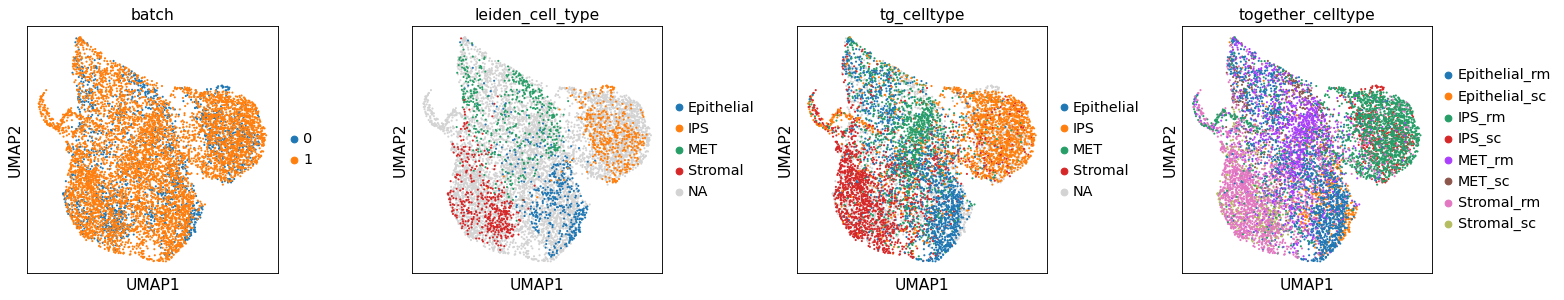

In [15]:
sc.pl.umap(together_recon, color=['batch', 'leiden_cell_type', 'tg_celltype', 'together_celltype'], wspace=0.4)

# pseudo-bulk correlations

/home/kkobayas/miniconda3/envs/gan/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/kkobayas/miniconda3/envs/gan/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


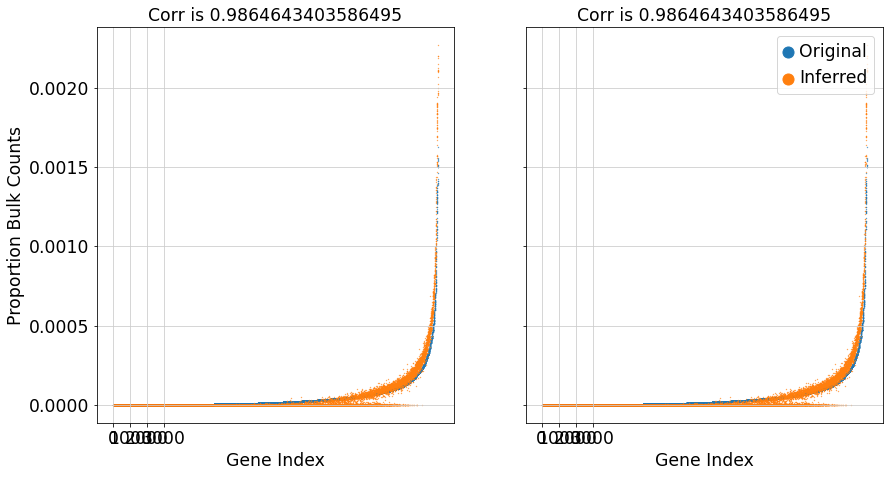

In [16]:
test_feature = omics_test.X.todense() / .1
# test_feature = omics_test.X / .1
test_feature_raman = raman_test.X / .1  # see if this helps 


# look at the correlation between the predicted and the actual

# this is for training data, not test

# this is on test 

if 1:
    orig_cells_dataset = (
        torch
        .from_numpy(test_feature)
        .float()
        .to('cpu')
    )


    orig_cells_dataset_raman = (
        torch
        .from_numpy(test_feature_raman)
        .float()
        .to('cpu')
    )


    transfer_vae = VAE(
        raman_vae.encoder,
        ref_vae.decoder,
        is_vae=False,
        use_latent_norm=True,  # was True for all else 
    )

    transfer_vae = transfer_vae.to('cpu')

    inferred_omics, _, _, latent_raman = transfer_vae(orig_cells_dataset_raman) 
    inferred_omics = inferred_omics.detach().numpy()
    original_omics = test_feature

    gene_to_corr = {}
    gene_to_orig = {}
    gene_to_inferred = {}
    
# also do this for test
good_genes = ['Bgn', 'Col1a1']
for gene in raman_genes:
    
    gene_index = list(omics_data.var.index).index(gene)
    orig_exp = np.array(raman_train.obs[gene])
    inferred_exp = inferred_omics[:, gene_index]
    new_orig_exp = np.array([x for x, y in zip(orig_exp, inferred_exp) if not np.isnan(x)])
    new_inferred_exp = np.array([y for x, y in zip(orig_exp, inferred_exp) if not np.isnan(x)])
    orig_exp = new_orig_exp
    inferred_exp = new_inferred_exp
    
#     orig_exp = orig_exp / np.sum(orig_exp)
#     inferred_exp = inferred_exp / np.sum(inferred_exp)
    
    
    
    corr_coef = np.corrcoef(orig_exp, inferred_exp)[0, 1]
    gene_to_corr[gene] = corr_coef
    gene_to_orig[gene] = orig_exp
    gene_to_inferred[gene] = inferred_exp
    
# mult by 10, see if helps
orig_sum = np.squeeze(np.array(
    np.sum(original_omics, axis=0) / np.sum(original_omics,)
))

inferred_sum = np.squeeze(
    np.sum(inferred_omics, axis=0) / np.sum(inferred_omics,)
)


%matplotlib inline

s=1e-1
scale=1

figs, axes = plt.subplots(
    1, 2, figsize=(14, 7),
)


# figs.suptitle('sdfsdf')
for i, fig in enumerate(axes):
    
    corr = np.corrcoef(orig_sum, inferred_sum)[0, 1]
    test_ord = np.argsort(orig_sum)
    fig.set_title(f'Corr is {corr}', fontsize='xx-large')
    
    # up to 3k
    fig.scatter(
        range(len(orig_sum)), orig_sum[test_ord],
        label="Original",
        marker='o', 
        s=s,
    )
    fig.scatter(
        range(len(inferred_sum)), inferred_sum[test_ord],
        label="Inferred",
        marker='o',
        s=s,
    )
    
    if i:
        fig.legend(
            loc='upper right',
            fontsize='xx-large',
            markerscale=35.,
        )

    fig.set_xticks(np.arange(0, 4000, 1000))
    for item in fig.get_yticklabels():
        item.set_fontsize('xx-large')
    for item in fig.get_xticklabels():
        item.set_fontsize('xx-large')
        
    
for fig in axes.flat:
#     fig.set(xlabel='Gene Index', ylabel='Proportion Bulk Counts')
    fig.set_xlabel('Gene Index', fontsize='xx-large')
    fig.set_ylabel('Proportion Bulk Counts', fontsize='xx-large')
for fig in axes.flat:
    fig.label_outer()



    

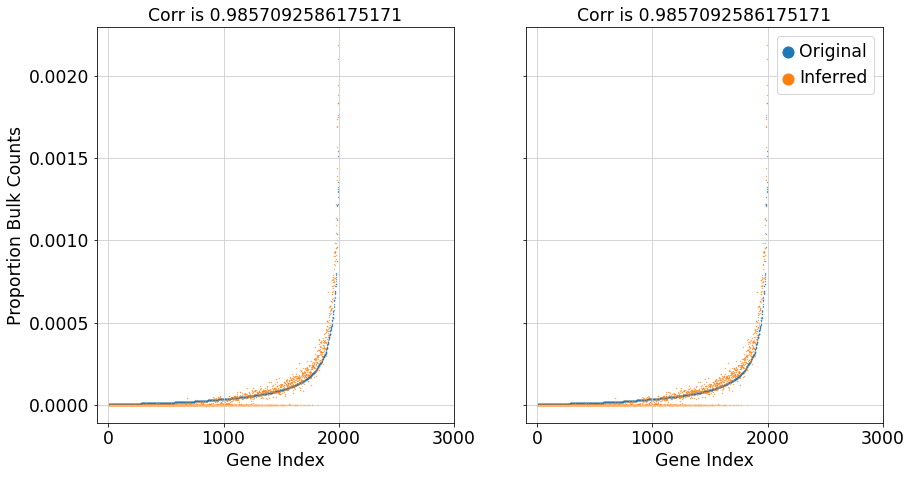

In [17]:
# find the highly variable correlations 
high_var_inds = np.where(omics_data.var['highly_variable'])
orig_sum = np.squeeze(np.array(
    np.sum(original_omics, axis=0) / np.sum(original_omics,)
))[high_var_inds]

inferred_sum = np.squeeze(
    np.sum(inferred_omics, axis=0) / np.sum(inferred_omics,)
)[high_var_inds]


%matplotlib inline

s=1e-1
scale=1

figs, axes = plt.subplots(
    1, 2, figsize=(14, 7),
)


# figs.suptitle('sdfsdf')
for i, fig in enumerate(axes):
    
    corr = np.corrcoef(orig_sum, inferred_sum)[0, 1]
    test_ord = np.argsort(orig_sum)
    fig.set_title(f'Corr is {corr}', fontsize='xx-large')
    
    # up to 3k
    fig.scatter(
        range(len(orig_sum)), orig_sum[test_ord],
        label="Original",
        marker='o', 
        s=s,
    )
    fig.scatter(
        range(len(inferred_sum)), inferred_sum[test_ord],
        label="Inferred",
        marker='o',
        s=s,
    )
    
    if i:
        fig.legend(
            loc='upper right',
            fontsize='xx-large',
            markerscale=35.,
        )

    fig.set_xticks(np.arange(0, 4000, 1000))
    for item in fig.get_yticklabels():
        item.set_fontsize('xx-large')
    for item in fig.get_xticklabels():
        item.set_fontsize('xx-large')
        
    
for fig in axes.flat:
#     fig.set(xlabel='Gene Index', ylabel='Proportion Bulk Counts')
    fig.set_xlabel('Gene Index', fontsize='xx-large')
    fig.set_ylabel('Proportion Bulk Counts', fontsize='xx-large')
for fig in axes.flat:
    fig.label_outer()


# see test data per-celltype pseudobulk

In [18]:
nanog_ind = list(omics_data.var.index).index('Nanog')

final_inferred_omics_adata = sc.AnnData(X=inferred_omics)
final_inferred_omics_adata.obs = raman_test.obs
omics_test_adata = sc.AnnData(X=test_feature)
omics_test_adata.obs = omics_test.obs

omics_test_adata.var.index = omics_data.var.index
final_inferred_omics_adata.var.index = omics_data.var.index


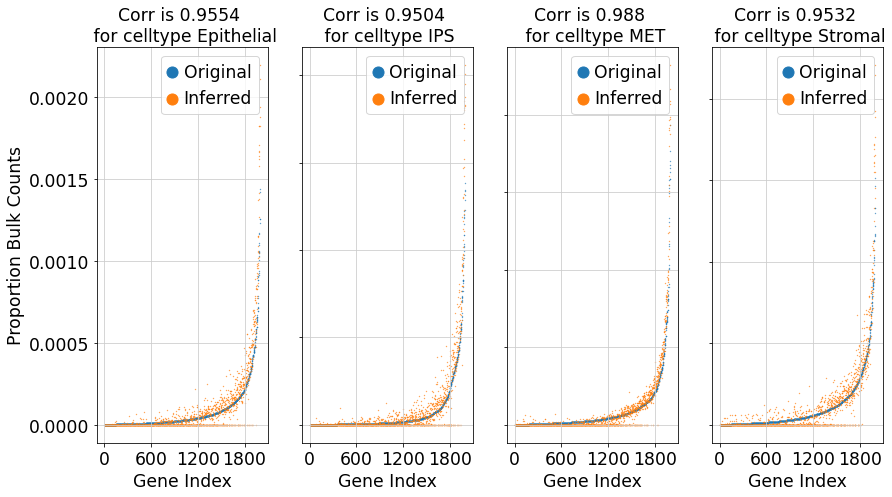

In [19]:
# high var each celltype 
%matplotlib inline

s=1e-1
scale=1

figs, axes = plt.subplots(
    1, 4, figsize=(14, 7),
)


# figs.suptitle('sdfsdf')
celltypes = ['Epithelial', 'IPS', 'MET', 'Stromal']
for celltype, fig in zip(celltypes, axes):
    
    ot = omics_test_adata[omics_test_adata.obs['leiden_cell_type']==celltype]
    it = final_inferred_omics_adata[final_inferred_omics_adata.obs['tg_celltype']==celltype]
    orig_sum = np.squeeze(np.array(
        np.sum(ot.X, axis=0) / np.sum(ot.X,)
    ))[high_var_inds]

    inferred_sum = np.squeeze(
        np.sum(it.X, axis=0) / np.sum(it.X,)
    )[high_var_inds]


    
    corr = round(np.corrcoef(orig_sum, inferred_sum)[0, 1], 4)
    test_ord = np.argsort(orig_sum)
    fig.set_title(f'Corr is {corr} \n for celltype {celltype}', fontsize='xx-large')
    
    # up to 3k
    fig.scatter(
        range(len(orig_sum)), orig_sum[test_ord],
        label="Original",
        marker='o', 
        s=s,
    )
    fig.scatter(
        range(len(inferred_sum)), inferred_sum[test_ord],
        label="Inferred",
        marker='o',
        s=s,
    )
    
    if i:
        fig.legend(
            loc='upper right',
            fontsize='xx-large',
            markerscale=35.,
        )

    fig.set_xticks(np.arange(0, 2000, 600))
    for item in fig.get_yticklabels():
        item.set_fontsize('xx-large')
    for item in fig.get_xticklabels():
        item.set_fontsize('xx-large')
        
    
for fig in axes.flat:
#     fig.set(xlabel='Gene Index', ylabel='Proportion Bulk Counts')
    fig.set_xlabel('Gene Index', fontsize='xx-large')
    fig.set_ylabel('Proportion Bulk Counts', fontsize='xx-large')
for fig in axes.flat:
    fig.label_outer()



## power analysis on HVGs

In [20]:
from collections import defaultdict

In [22]:
'''high var celltype power analysis'''
from scipy.stats import pearsonr
import random
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

s=1e-1
scale=1

celltypes = ['Epithelial', 'IPS', 'MET', 'Stromal']
# ct_to_corrs = defaultdict(list)
num_boot = 5

# num_ot = (ot.shape)[0]
# num_it = (it.shape)[0]
num_it = (final_inferred_omics_adata.shape)[0]

# number of cells used to do power analysis
diff_num_its = [6391, 3834, 1278, 639, 127, 0]
print(diff_num_its)
corrs = []

omics = sc.pp.log1p(omics_test_adata, copy=True)
omics = sc.pp.scale(omics_test_adata, copy=True)
infs = sc.pp.log1p(final_inferred_omics_adata, copy=True)
infs = sc.pp.scale(final_inferred_omics_adata, copy=True)

rna_avg = np.mean(omics.X, axis=0)[high_var_inds]


corrs_power = defaultdict(list)
for ni in diff_num_its:
    corr_list = defaultdict(list)
    print(ni)
    for _ in range(num_boot):
        if ni>0:
            its = infs[random.sample(range(num_it), ni),:]

        for celltype in celltypes:
            ot = omics[omics.obs['leiden_cell_type']==celltype,:]
            it = its[its.obs['tg_celltype']==celltype,:]

            inferred_sum = np.mean(it.X, axis=0)[high_var_inds]
            orig_sum = np.mean(ot.X, axis=0)[high_var_inds]

            if ni>0:
                # corr = round(pearsonr(orig_sum, inferred_sum)[0], 4)
                corr = round(cosine_similarity([orig_sum], [inferred_sum])[0,0], 4)
            else:
                # cosine correlations of average profiles calculated in the anchored-version notebook
                if celltype == 'Epithelial':
                    corr = 0.07300752308541941
                elif celltype == 'IPS':
                    corr = -0.0063809840107011285
                elif celltype == 'MET':
                    corr = -0.03266286145208243
                elif celltype == 'Stromal':
                    corr = -0.025395262274916085

            # print(celltype, corr)
            corr_list[celltype].append(corr)
        # add corr with avg

    corrs_power[ni].append(corr_list)
# corrs_power

[6391, 3834, 1278, 639, 127, 0]
6391
3834
1278
639
127
0


In [23]:
round(np.corrcoef(rna_avg, inferred_sum)[0, 1], 4)

ct_corrs = defaultdict(list)
for celltype in celltypes:
    corrs_mat = np.zeros((num_boot, len(diff_num_its)))
    for diff_num_i, diff_num in enumerate(list(corrs_power.keys())):
        for boot_i in range(num_boot):
            # print(corrs_power[diff_num][0])
            corrs_mat[boot_i, diff_num_i] = corrs_power[diff_num][0][celltype][boot_i]
    ct_corrs[celltype] = corrs_mat
# ct_corrs

Text(0.5, 0, 'Number of training cells')

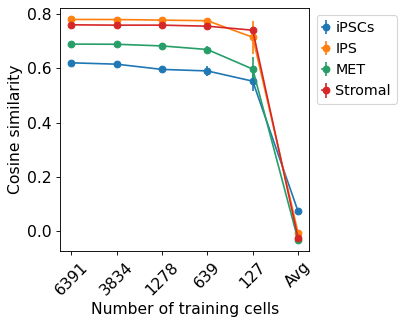

In [24]:
sc.set_figure_params()
plt.grid(False)
cell_sizes = list(corrs_power.keys())
for ct in celltypes:
    raman_r = ct_corrs[ct]
    raman_r_avg = np.mean(raman_r, axis=0)
    raman_r_std = np.std(raman_r, axis=0)
    
    raman_r_norm = raman_r/raman_r_avg[0]
    raman_r_norm_avg = np.mean(raman_r_norm, axis=0)
    raman_r_norm_std = np.std(raman_r_norm, axis=0)
    
    # plt.errorbar(range(len(cell_sizes)+1), raman_r_avg, yerr=raman_r_std, fmt="-o")
    plt.errorbar(range(len(cell_sizes)), raman_r_avg, yerr=raman_r_std, fmt="-o")

plt.xticks(ticks=range(len(cell_sizes)), labels=[str(t) for t in cell_sizes[:-1]]+['Avg'], rotation=45)
plt.ylabel('Cosine similarity')
# plt.ylabel('Relative Pearson $\it{r}$')
# plt.legend(['Raman2RNA', 'Fake profile'], loc='lower left')
# leg = sample_sizes
# leg = test_sizes
# leg.append('Fake profile')
cts = celltypes.copy()
mask = cts=='IPS'
cts[mask] = 'iPSCs'
plt.legend(cts, loc='best',bbox_to_anchor=(1,1))
plt.xlabel('Number of training cells')
# plt.savefig('figures/power_cells_vs_fakeGE_hvg.pdf')

# print(sample_sizes)

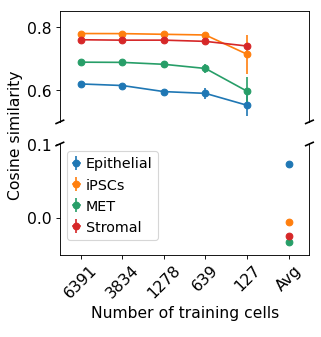

In [25]:
"""
Broken axis example, where the y-axis will have a portion cut out.
"""
# plt.grid(False)
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f, (ax, ax2) = plt.subplots(2, 1, sharex=False)
# f, (ax, ax2) = plt.subplots(2, 1, sharex=True)


cell_sizes = list(corrs_power.keys())[:-1]
for ct in celltypes:
    raman_r = ct_corrs[ct]
    raman_r_avg = np.mean(raman_r, axis=0)
    raman_r_std = np.std(raman_r, axis=0)
    
    raman_r_norm = raman_r/raman_r_avg[0]
    raman_r_norm_avg = np.mean(raman_r_norm, axis=0)
    raman_r_norm_std = np.std(raman_r_norm, axis=0)
    
    # plt.errorbar(range(len(cell_sizes)+1), raman_r_avg, yerr=raman_r_std, fmt="-o")
    ax.errorbar(range(len(cell_sizes)), raman_r_avg[:-1], yerr=raman_r_std[:-1], fmt="-o")
    ax2.errorbar(range(len(cell_sizes)+1)[-1], raman_r_avg[-1], yerr=raman_r_std[-1], fmt="-o")

# cell_sizes = sample_sizes[::len(test_sizes)][:len(test_sizes)]
# for i in range(len(celltypes)):
#     raman_r = raman_rs[i]
#     raman_r_avg = np.mean(raman_r, axis=0)
#     raman_r_std = np.std(raman_r, axis=0)
    
#     raman_r_norm = raman_r/raman_r_avg[0]
#     raman_r_norm_avg = np.mean(raman_r_norm, axis=0)
#     raman_r_norm_std = np.std(raman_r_norm, axis=0)

#     # plot the same data on both axes
#     ax.errorbar(range(len(cell_sizes)), raman_r_avg[:-1], yerr=raman_r_std[:-1], fmt="-o")

# zoom-in / limit the view to different portions of the data
ax.set_xlim([-0.5, len(cell_sizes)+0.5] )
ax2.set_xlim([-0.5, len(cell_sizes)+0.5] )

# ax2.set_xlim(range(len(cell_sizes)+1))
ax.set_ylim(.5, 0.85)  # most of the data
ax2.set_ylim(-0.05, 0.1)  # outliers only
ax.grid(False)
ax2.grid(False)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

cts = np.array(celltypes.copy())
mask = cts=='IPS'
cts[mask] = 'iPSCs'
plt.legend(cts, loc='best')#,bbox_to_anchor=(1,1))

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

ax2.set_xticks(ticks=range(len(cell_sizes)+1), )
ax2.set_xticklabels(labels=[str(t) for t in cell_sizes]+['Avg'], rotation=45)

plt.ylabel('                          Cosine similarity')


plt.xlabel('Number of training cells')

ax.set_xticks([])
# ax.set_xticks([]
plt.savefig('figures/power_cells_vs_fakeGE_hvg_anchorfree.pdf')

plt.show()

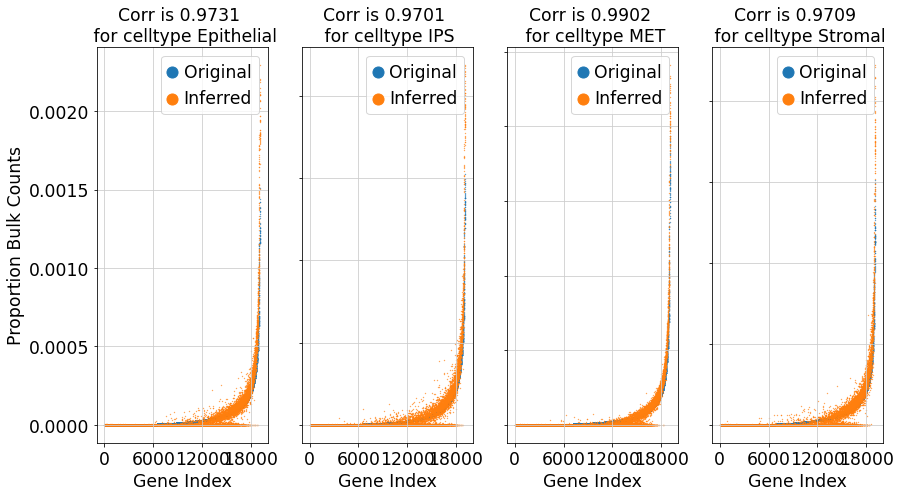

In [26]:
%matplotlib inline

s=1e-1
scale=1

figs, axes = plt.subplots(
    1, 4, figsize=(14, 7),
)


# figs.suptitle('sdfsdf')
celltypes = ['Epithelial', 'IPS', 'MET', 'Stromal']
for celltype, fig in zip(celltypes, axes):
    
    ot = omics_test_adata[omics_test_adata.obs['leiden_cell_type']==celltype]
    it = final_inferred_omics_adata[final_inferred_omics_adata.obs['tg_celltype']==celltype]
    orig_sum = np.squeeze(np.array(
        np.sum(ot.X, axis=0) / np.sum(ot.X,)
    ))

    inferred_sum = np.squeeze(
        np.sum(it.X, axis=0) / np.sum(it.X,)
    )


    
    corr = round(np.corrcoef(orig_sum, inferred_sum)[0, 1], 4)
    test_ord = np.argsort(orig_sum)
    fig.set_title(f'Corr is {corr} \n for celltype {celltype}', fontsize='xx-large')
    
    # up to 3k
    fig.scatter(
        range(len(orig_sum)), orig_sum[test_ord],
        label="Original",
        marker='o', 
        s=s,
    )
    fig.scatter(
        range(len(inferred_sum)), inferred_sum[test_ord],
        label="Inferred",
        marker='o',
        s=s,
    )
    
    if i:
        fig.legend(
            loc='upper right',
            fontsize='xx-large',
            markerscale=35.,
        )

    fig.set_xticks(np.arange(0, 20000, 6000))
    for item in fig.get_yticklabels():
        item.set_fontsize('xx-large')
    for item in fig.get_xticklabels():
        item.set_fontsize('xx-large')
        
    
for fig in axes.flat:
#     fig.set(xlabel='Gene Index', ylabel='Proportion Bulk Counts')
    fig.set_xlabel('Gene Index', fontsize='xx-large')
    fig.set_ylabel('Proportion Bulk Counts', fontsize='xx-large')
for fig in axes.flat:
    fig.label_outer()



# celltype pseudobulk relative correlation matrix 

In [27]:
high_var_inds = np.where(omics_data.var['highly_variable'])


In [ ]:
import seaborn as sns

In [ ]:
# figs.suptitle('sdfsdf')
orr_pred_to_corr = {}
inferred_omics_adata = final_inferred_omics_adata
high_var_inds = np.where(omics_data.var['highly_variable'])

for co in (celltypes):
    for cp in (celltypes):
    
        ot = omics_test_adata[omics_test_adata.obs['leiden_cell_type']==co]
        it = inferred_omics_adata[inferred_omics_adata.obs['tg_celltype']==cp]
        
#         ot = inferred_omics_adata[inferred_omics_adata.obs['tg_celltype']==co]
#         it = omics_test_adata[omics_test_adata.obs['leiden_cell_type']==cp]
        
        orig_sum = np.squeeze(np.array(
            np.sum(ot.X, axis=0) / np.sum(ot.X,)
        ))

        inferred_sum = np.squeeze(
            np.sum(it.X, axis=0) / np.sum(it.X,)
        )
        
        test_ord = np.argsort(orig_sum)
        
        if 0:
            orig_sum = orig_sum[test_ord][15000:]
            inferred_sum = inferred_sum[test_ord][15000:]
            
        if 1:
            orig_sum = orig_sum[high_var_inds]
            inferred_sum = inferred_sum[high_var_inds]



        corr = round(np.corrcoef(orig_sum, inferred_sum)[0, 1], 4)
        orr_pred_to_corr[(co, cp)] = corr
        
if 1:
    celltype_to_ind = {
        'Epithelial': 0,
        'IPS': 1,
        'MET': 2,
        'Stromal': 3,
    }

    matr = np.zeros((4, 4))
    for (co, ci), v in orr_pred_to_corr.items():
        co = celltype_to_ind[co]
        ci = celltype_to_ind[ci]
        matr[co, ci] = v
        
if 0:
    plt.imshow(matr, cmap='seismic', vmin=-1, vmax=1)        
    plt.colorbar()

if 0:
    plt.imshow((matr - np.mean(matr)) / ((np.var(matr))**.5), cmap='seismic',)
    plt.colorbar()
    
if 0:    
    # for each row, subt mean, then div by std dev
    plt.imshow(
        (matr - matr.mean(axis=1)) / ((matr.var(axis=1))**.5),
               cmap='seismic', vmin=-1, vmax=1
              )
    plt.colorbar()
    
if 1:
    g = sns.clustermap(matr, annot=matr, z_score=0, cmap='RdBu_r', row_cluster=False, col_cluster=False, cbar_pos=(0.08, 0.4, 0.05, 0.18), figsize=(7.6,7))
    g.ax_heatmap.set_xticklabels(celltypes, Fontsize=9.2)
    g.ax_heatmap.set_yticklabels(celltypes, Fontsize=9.2)


In [ ]:
# why is the correlation so much stronger w other celltypes?
matr


### classify time points

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, mean_squared_error, r2_score, ConfusionMatrixDisplay
import catboost
from catboost import CatBoostClassifier, Pool, cv
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import seaborn as sns

In [34]:
'''build catboost classifier for time points'''
ad_tr = final_inferred_omics_adata.copy()
pca = PCA(n_components=50)
pcs_tr = pca.fit_transform(ad_tr.X)

days = [str(d) for d in ad_tr.obs.day]
X_tr_trn, X_tr_tst, Y_tr_trn, Y_tr_tst = train_test_split(pcs_tr, days, test_size=0.5)

model_class = CatBoostClassifier(random_seed=2020, early_stopping_rounds=5, silent=True);
model_class.fit(X_tr_trn, Y_tr_trn)

results = model_class.predict(X_tr_tst)

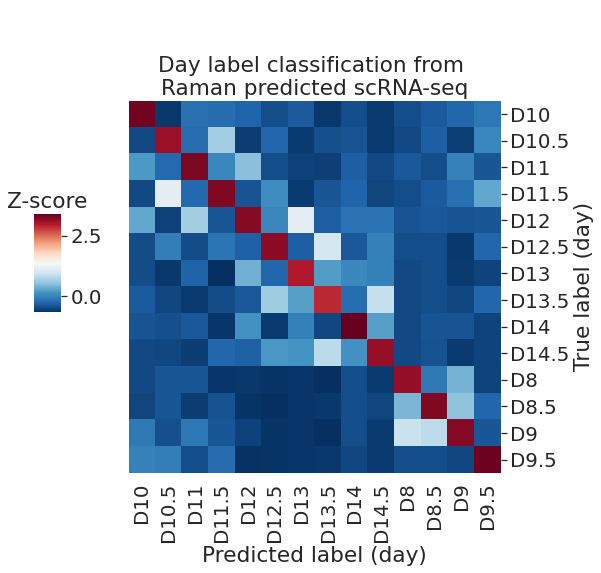

In [38]:
# day = [str(d) for d in days]
cm = confusion_matrix(Y_tr_tst, list(results.squeeze()), labels=days_s)
# g = sns.clustermap(cm, annot=cm, cmap='RdBu_r', row_cluster=False, col_cluster=False, cbar_pos=(0.08, 0.4, 0.05, 0.18), figsize=(20,20))
g = sns.clustermap(cm, cmap='RdBu_r', z_score=1, row_cluster=False, col_cluster=False, cbar_pos=(0.04, 0.4, 0.05, 0.18), figsize=(7.6,7.6))
# g = sns.clustermap(corr_sub, z_score=0, cmap='RdBu_r', row_cluster=False, col_cluster=False, cbar_pos=(0.08, 0.4, 0.05, 0.18), figsize=(7.6,7))
# g.set_title(ct)
g.ax_heatmap.set_title('Day label classification from \nRaman predicted scRNA-seq')
g.ax_heatmap.set(xlabel='Predicted label (day)', ylabel='True label (day)')

g.ax_heatmap.set_xticklabels(days_s)
g.ax_heatmap.set_yticklabels(days_s)

plt.title('Z-score')
sns.set(font_scale=1.8)
# sns.set(font_scale=1)
# plt.title('Accuracy')
plt.savefig('figures/days_classification_confusion_mat_zscore.pdf')